In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf
from datetime import datetime, timedelta
from arch import arch_model
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [76]:
df = pd.read_csv("C:\\Users\\Bogdan\\OneDrive - University of Warwick\\Desktop\\Temp prediction\\MIDLAND TEXAS, TX US.csv")
df['DATE'] = pd.to_datetime(df['DATE'], format="%Y-%m-%d")
df = df.set_index('DATE')
df['TCELCIUS'] = (df['TAVG'] - 32) * 5 / 9
df = df.drop(columns=['TMAX', 'TMIN', 'STATION', 'TAVG'])
df = df.asfreq(pd.infer_freq(df.index))
df = df.resample('M').mean()

In [77]:
train_end = datetime(2024, 1, 31)
test_end = datetime(2024, 7, 31)

train_data = df[:train_end + timedelta(days=1)]
test_data = df[train_end + timedelta(days=1):]  # 6 months

In [78]:
integrated_order = (0, 1, 0)
seasonal_order = (1, 0, 1, 12)

rolling_predictions_SARIMAX = pd.Series(index=test_data.index)
rolling_predictions_GARCH = pd.Series(index=test_data.index)

In [79]:
for i in test_data.index:
    train_data = df[:i]
    model = SARIMAX(train_data, order=integrated_order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)
    forecast = model_fit.forecast(steps=1)
    rolling_predictions_SARIMAX.loc[i] = forecast.values[0]#forecast is an actual pd series so you must extract values form it like imagine for more steps it stores the predictions somewhere, you indexed it before and straight up ploted it like that doesn't work if u get raw values

c:\Users\Bogdan\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\Bogdan\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\Bogdan\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\Bogdan\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observa

In [80]:
for i in test_data.index:
    train_data = df[:i]
    residuals = SARIMAX(train_data, order=integrated_order, seasonal_order=seasonal_order).fit(disp=False).resid #the residuals are calculated in the training stage where the model does reveal the furmula if will use to forecast the nest observation, that formula is updated but the residual is recorded without the need to specify the model to forecast anything + residuals is a series
    model = arch_model(residuals, p=1, q=1) #len(residuals) = len(training_data)
    model_fit = model.fit(disp="off")
    garch_forecast = model_fit.forecast(horizon=1).variance.values[0]#agaian forecast spits an object containing variances so u must extract the value(s)
    rolling_predictions_GARCH.loc[i] = np.sqrt(garch_forecast)

c:\Users\Bogdan\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\Bogdan\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\Bogdan\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\Bogdan\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observa

In [81]:
the_actual_forecast = rolling_predictions_SARIMAX + rolling_predictions_GARCH * np.random.normal(size=len(test_data))
#So, while the residuals themselves are random and not predictable, the degree to which they are random (their variance) can show patterns and be modeled, making it possible to forecast the variability in future residuals.

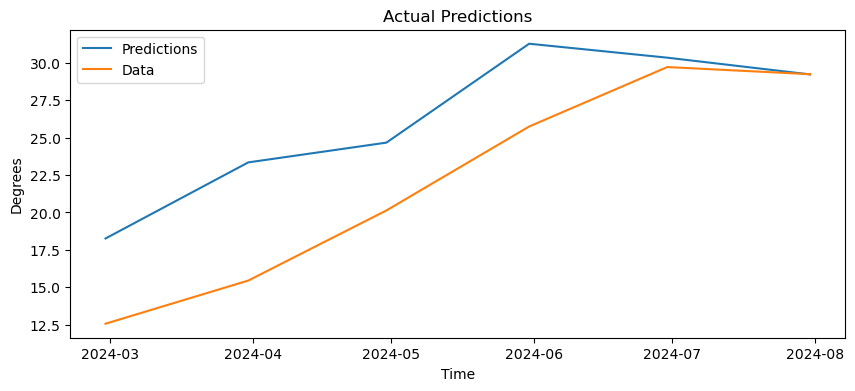

In [82]:
plt.figure(figsize=(10, 4))
plt.plot(the_actual_forecast, label='Predictions')
plt.plot(test_data, label='Data')
plt.title('Actual Predictions')
plt.ylabel('Degrees')
plt.xlabel('Time')
plt.legend()
plt.show()

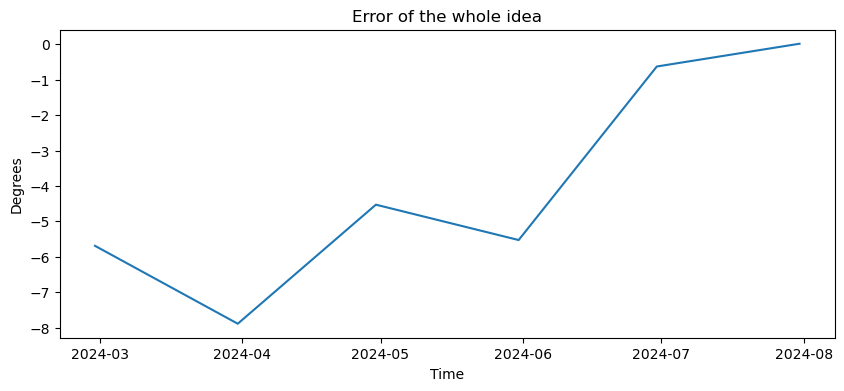

In [83]:
idea_error = test_data['TCELCIUS'] - the_actual_forecast

plt.figure(figsize=(10, 4))
plt.plot(idea_error)
plt.title('Error of the whole idea')
plt.ylabel('Degrees')
plt.xlabel('Time')
plt.show()

In [84]:
print('Mean abs % error:',np.mean(abs(idea_error/test_data['TCELCIUS'])))

Mean abs % error: 0.2375219009775593


In [86]:
print('Root mean squared error (degrees):', np.sqrt(np.mean(idea_error**2)))

Root mean squared error (degrees): 4.934906745726875
